## Importing Libraries and Data

In [7]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [8]:
quandl.ApiConfig.api_key = 'UcnL-iVVggn5a2gJmPgU'

In [9]:
# Import Zillow Data
data = quandl.get_table('ZILLOW/DATA')

In [10]:
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2024-07-31,486230.166077
1,ZSFH,99999,2024-06-30,485893.210056
2,ZSFH,99999,2024-05-31,484599.091201
3,ZSFH,99999,2024-04-30,481777.608669
4,ZSFH,99999,2024-03-31,480423.651093


In [11]:
# Check shape of the data 
data.shape

(10000, 4)

In [12]:
data.columns

Index(['indicator_id', 'region_id', 'date', 'value'], dtype='object')

In [13]:
# Create a subset containing the date and value column
data_subset = data[['date', 'value']]

In [14]:
data_subset

,date,value
None,,
0,2024-07-31,486230.166077
1,2024-06-30,485893.210056
2,2024-05-31,484599.091201
3,2024-04-30,481777.608669
4,2024-03-31,480423.651093
...,...,...
9995,2017-04-30,327998.635842
9996,2017-03-31,324828.631501
9997,2017-02-28,321684.047119


In [15]:
grouped = data_subset.groupby('date').sum().reset_index()

In [16]:
grouped

,date,value
0,1996-01-31,1.008741e+06
1,1996-02-29,1.012477e+06
2,1996-03-31,1.014454e+06
3,1996-04-30,1.018547e+06
4,1996-05-31,1.024531e+06
...,...,...
338,2024-03-31,1.474094e+07
339,2024-04-30,1.480686e+07
340,2024-05-31,1.487177e+07
341,2024-06-30,1.491676e+07


In [17]:
# Set the "Date" column as the index

from datetime import datetime

grouped['datetime'] = pd.to_datetime(grouped['date']) # Create a datetime column from "Date.""
grouped = grouped.set_index('datetime') # Set the datetime as the index of the dataframe.
grouped.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
grouped.head()

,value
datetime,
1996-01-31,1008741.0
1996-02-29,1012477.0
1996-03-31,1014454.0
1996-04-30,1018547.0
1996-05-31,1024531.0


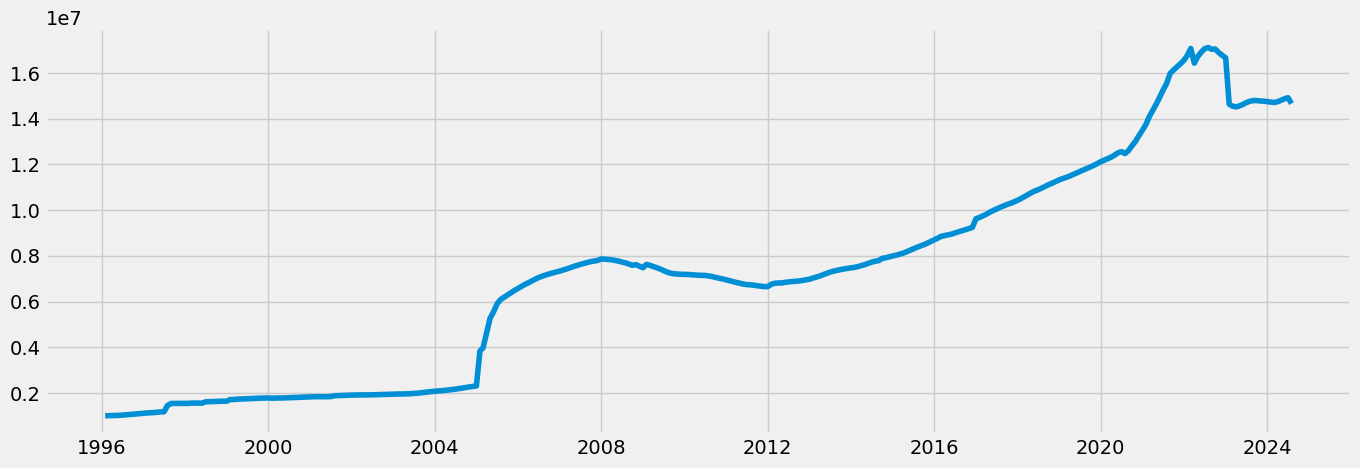

In [18]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(grouped)

In [19]:
# Check for missing values
grouped.isnull().sum() 

value    0
dtype: int64

In [20]:
# Check for duplicates

dups = grouped.duplicated()
dups.sum()

# No dups!

0

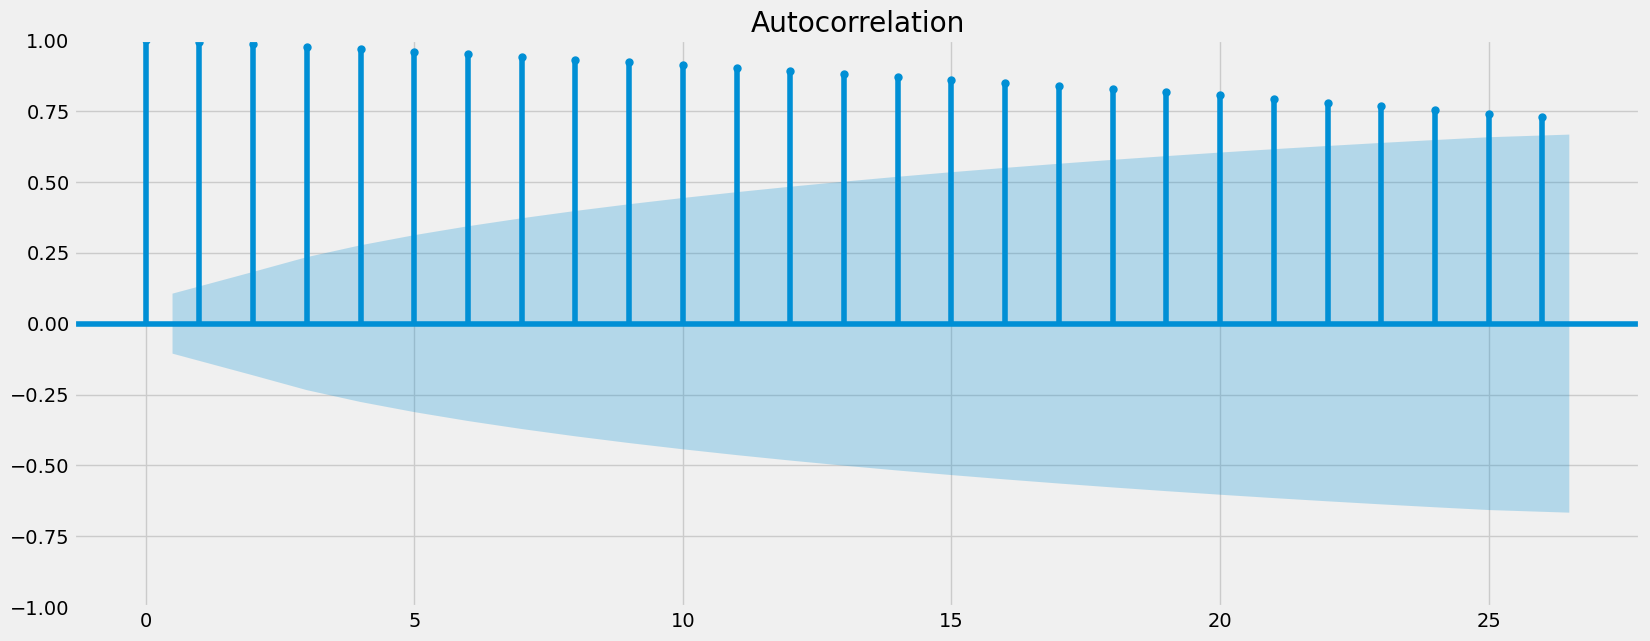

In [59]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(grouped)
plt.show()

## Time Series Analysis: Decomposition

In [22]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(grouped,period=60, model='additive')

In [23]:
# Define fixed size
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

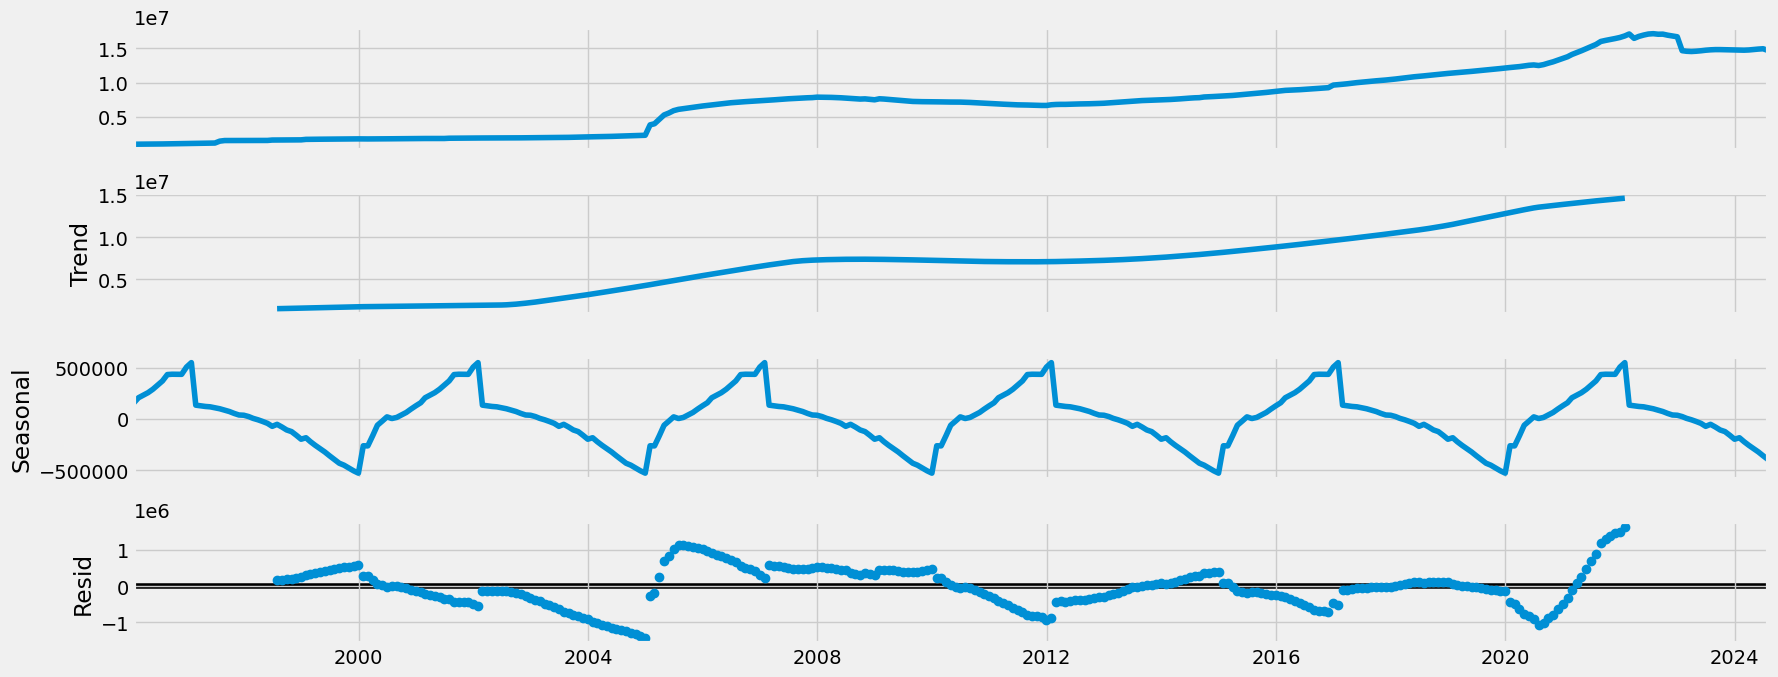

In [24]:
# Plot the separate components
decomposition.plot()
plt.show()

##### Observations
Trend: Aside from a few minor dips, there was a general upward trend in values. 

Seasonal: seasonality fluctuations occur at a relatively fixed interval.

## Test for Stationarity

In [28]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(grouped['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.829147
p-value                          0.810410
Number of Lags Used             10.000000
Number of Observations Used    332.000000
Critical Value (1%)             -3.450201
Critical Value (5%)             -2.870285
Critical Value (10%)            -2.571429
dtype: float64


Alternate Hypothesis: Over time, there is a general upward trend in housing prices. 

Null Hypothesis: Over time, there is a general downward in housing prices

Because the P-value is greater than 0.05, this indicates that the test statistic is not significant. Considering that the test statistic is not smaller than the critical value, the null hypothesis cannot be rejected. 

## Stationarizing Zillow Data 

In [36]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff = grouped - grouped.shift(1) 

In [38]:
# Remove any missing values due to result of differencing
data_diff.dropna(inplace = True) 

In [40]:
# Check results of differencing 
data_diff.head()

,value
datetime,
1996-02-29,3736.0
1996-03-31,1977.0
1996-04-30,4093.0
1996-05-31,5984.0
1996-06-30,9375.0


In [42]:
data_diff.columns

Index(['value'], dtype='object')

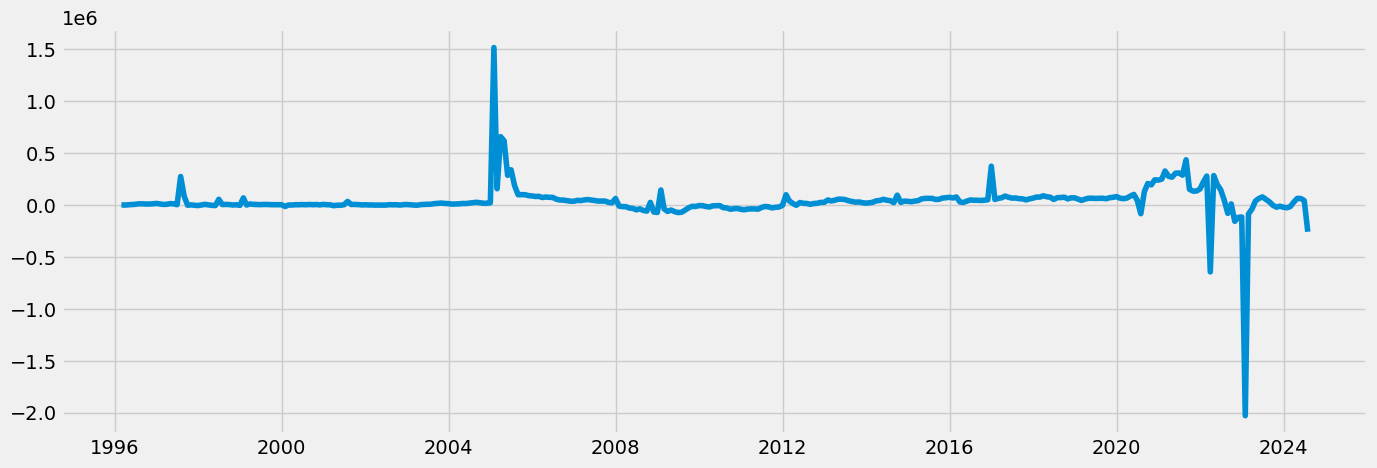

In [44]:
# Analyze time series after differencing 

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [47]:
# Conduct a dickey-fuller test to analyze statistical measures after stationarizing technique
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.677437
p-value                          0.004442
Number of Lags Used              9.000000
Number of Observations Used    332.000000
Critical Value (1%)             -3.450201
Critical Value (5%)             -2.870285
Critical Value (10%)            -2.571429
dtype: float64


After performing the differencing method, the P-value is less than 0.05 indicating the test statistic is significant. In addition, the test statistic is higher than the critical value which confirms a rejected hypothesis. Time series is now considered stationary

## Check Zillow Data Autocorrelation

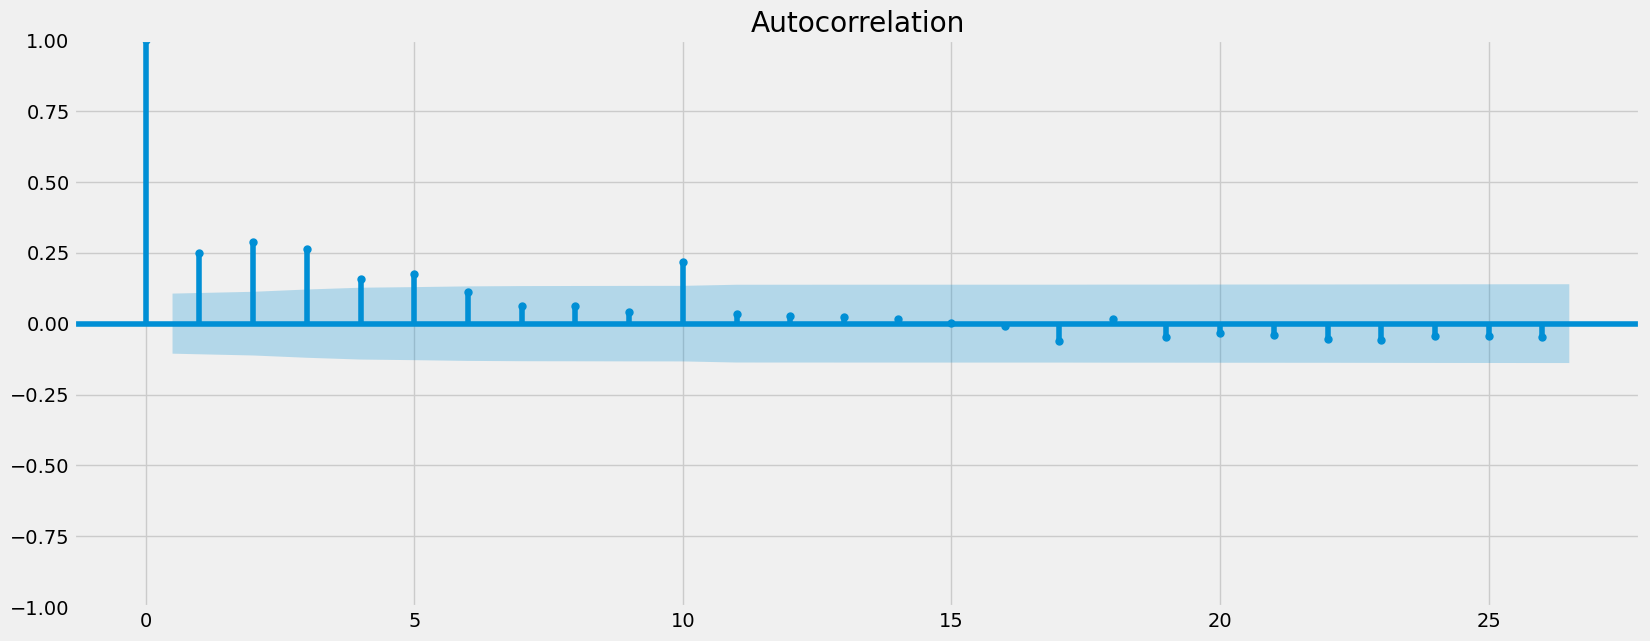

In [55]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff)
plt.show()